In [1]:
import networkx as nx
import numpy as np
from itertools import chain,combinations
import itertools
import pandas as pd
import sys
from tqdm.notebook import tqdm, trange
import time

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [2]:
def powerset(iterable):
    "powerset([1,2,3]) --> () (1,) (2,) (3,) (1,2) (1,3) (2,3) (1,2,3)"
    s = list(iterable)
    return chain.from_iterable(combinations(s, r) for r in range(len(s)+1))

In [3]:
def delete_edges_from(graph, vertex):
    e = graph.adj[vertex]
    for linked in list(e):
        graph.remove_edge(vertex,linked)

In [4]:
def sort_by_metric_func(graph):
    return list(graph.nodes())

In [5]:
def get_metric_ranking(rankings, num):
    return rankings.index(num)

In [6]:
# Eqn 2 in diversification paper
def calc_compdist_from(graph, i, j, lam):
    
    dimension_dist = 0
    i_props = graph.nodes[i]
    j_props = graph.nodes[j]
    ranking_i = i_props['m0']
    ranking_j = j_props['m0']
    #print("ranking_i" + str(ranking_i))
    #print("ranking_j" + str(ranking_j))
    
    # Get the properties
    for k,v in i_props.items():
        # Dimension values only
        if k.startswith("d"):
            dist = (v - j_props[k])
            dimension_dist += (dist ** 2.0)
            
    comp_value = ranking_i + ranking_j + 2 * lam * np.sqrt(dimension_dist)
    #print("dimension_dist = " + str(dimension_dist))
    #print("comp_value = " + str(comp_value))
    return comp_value
    

In [7]:
def find_max_weight_edge(sim_graph, lam):
    max_weight = -1
    tu = 0
    tv = 0
    vertex_count = sim_graph.number_of_nodes()
    for u in range(0,vertex_count):
        linked_nodes = sim_graph.adj[u]
        for v in list(linked_nodes):
            w = calc_compdist_from(sim_graph, u, v, lam)
            #print("u="+str(u) + "," + str(v) + ",weight=" + str(w))
            if (w > max_weight):
                tu = u
                tv = v
                max_weight = w
    return tu,tv, max_weight

In [8]:
def get_total_weight_selected_nodes(simgraph, nodes,lam):
    total_weight = 0
    for i in nodes:
        for j in nodes:
            total_weight += calc_compdist_from(simgraph, i, j, lam)
            
    return total_weight

In [9]:
a = nx.Graph()
a.add_node(5)
a.add_node(7)
a.add_node(4)
a.nodes

NodeView((5, 7, 4))

In [10]:
# Need to add arbitrary vertex
def max_sum_divergence_approx(sim_graph, phy_count, lam):
    Phy = nx.Graph() 
    lim = int(np.floor(phy_count/2))
    for i in range(0,lim):
        mu, mv, weight = find_max_weight_edge(sim_graph, lam)
        if (mu != mv):
            print("Max weight: " + str(mu) + "->" + str(mv) + ",weight=" + str(weight))
            Phy.add_node(mu)
            Phy.add_node(mv)
            Phy.add_edge(mu,mv)
            print("Number of nodes in Phy=" + str(Phy.number_of_nodes()))
            # remove other connected edges from mu and mv in the sim_graph
            delete_edges_from(sim_graph, mu)
            delete_edges_from(sim_graph, mv)
            # check further
        
    # If phy_count is odd, add a random vertex
    # for now, only use an even phy_count
    
    total_weight = get_total_weight_selected_nodes(sim_graph, Phy.nodes ,lam)
    return Phy

In [11]:
def gen_node_props(metrics_count, dim_count, metric_max, dim_max):
    nodeprops = {}
    metrics = []
    
    for di in range(0, dim_count):
        rand_dim = np.random.uniform(low=0, high=dim_max)
        nodeprops["d" + str(di)] = rand_dim
        
    # Generate the metrics
    for mi in range(0,metrics_count):
        rand_metric = np.random.uniform(low=0, high=metric_max)
        metrics.append(rand_metric)
        nodeprops["m" + str(mi)] = rand_metric
    return nodeprops

In [12]:
def create_random_sim_graph(node_count, metric_count, metric_max, dim_count, dim_max):
    sim = nx.Graph();
    for i in range(0,node_count):
        sim.add_nodes_from([(i, gen_node_props(metric_count, dim_count, metric_max, dim_max))])
        
    for i in range(0, node_count):
        for j in range(0, node_count):
            if (i != j):
                sim.add_edge(i,j)

    print("Edges: = " + str(sim.number_of_edges()))
    return sim

In [13]:
def read_node_props_from_dataframe(data, i, chosen_dimensions):
    # map the selected columns in chosen_dimensions into 'd0'
    dim_num = 0
    node_props = {}
    for d in chosen_dimensions:
        dim_id = "d" + str(dim_num)
        node_props[dim_id] = data.loc[i, d]
        dim_num += 1
    node_props['m0'] = data.loc[i, "METRIC_Q"]
    node_props['NAME'] = data.loc[i, "NAME"]
    
    # Set flag if it is on the pareto front
    node_props["TESTTAG"] = data.loc[i, "TESTTAG"]        
    return node_props

In [14]:
def create_sim_graph_from_data(filename_csv, chosen_dimensions):
    sim = nx.Graph();
    data = pd.read_csv(filename_csv)
    node_count = len(data)
    for i in range(0,node_count):
        sim.add_nodes_from([(i, read_node_props_from_dataframe(data, i, chosen_dimensions))])
        
    for i in range(0, node_count):
        for j in range(0, node_count):
            if (i != j):
                sim.add_edge(i,j)
    return sim

In [15]:
def extend_dim_boundaries_if_needed(boundaries, dim_id, value):
    if dim_id in boundaries:
        interval = boundaries[dim_id]
        if not (value in interval):
            if value < interval.left:
                boundaries[dim_id] = pd.Interval(value, interval.right)
            if value > interval.right:
                boundaries[dim_id] = pd.Interval(interval.left, value)
    else:
        boundaries[dim_id] = pd.Interval(value,value, 'both')

In [16]:
# Get the maximum and minimum of particular dimensions
def find_dimensional_boundaries(simgraph):
    boundaries = {}
    node_count = len(simgraph.nodes)
    for i in range(0, node_count):
        for k,v in simgraph.nodes[i].items():
            if k.startswith("d"):
                extend_dim_boundaries_if_needed(boundaries, k, v)
    return boundaries

In [17]:
def normalise_value(bound_interval,v):
    return (v - bound_interval.left) / bound_interval.length

In [18]:
def normalise_dimensions(simgraph):
    boundaries = find_dimensional_boundaries(simgraph)
    simgraph_out = nx.Graph()
    node_count = len(simgraph.nodes())
    for i in range(0, node_count):
        new_props = {}
        for k,v in simgraph.nodes[i].items():
            if k.startswith("d"):
                bound_interval = boundaries[k]
                new_props[k] = normalise_value(bound_interval, v)
            else:
                new_props[k] = v
                
        simgraph_out.add_nodes_from([(i, new_props)])
                
    for i in range(0, node_count):
        for j in range(0, node_count):
            if (i != j):
                simgraph_out.add_edge(i,j)
                
    return simgraph_out

In [19]:
# TODO: simple ranking function is the sum of the metrics
# TODO: metrics would need to be scaled somehow
def ranking_func(graph,node_id):
    props = graph.nodes[node_id]
    total = 0
    for k,v in props.items():
        if "m" in k:
            total += v
    return total

In [20]:
# dist_sum theoretical max = k * (k-1) * sqrt(param_space_num_dimesions)
# assuming all dimensions are properly normalised from zero to one!

# weight_sum theortical max = k * max_rank

In [21]:
def calc_subset_value_function(graph, dim_count, subset_inds, lam):
    k = len(subset_inds)
    weight_sum = 0
    for ni in subset_inds:
    # ranking_func is w in the equation
        weight_sum += ranking_func(graph, ni)
    
    # Are we double counting the distance here?
    # dist_sum has to be normalised over the number of dimensions?
    # the 2 is to compensate for counting them only once?
    # not needed here?
    dist_sum = 0
    for ni in subset_inds:
        for nj in subset_inds:
            dist_sum += dist_func(graph, ni,nj)
            
    dist_sum_scaled = dist_sum / np.sqrt(dim_count) 
    print(subset_inds, dist_sum_scaled)
            
    total = (1-lam)*(k-1)*weight_sum + 2*lam*dist_sum_scaled
    return total

In [22]:
def dist_func(graph, ni, nj):
    i_props = graph.nodes[ni]
    j_props = graph.nodes[nj]
    dimension_dist = 0.0
    for k,v in i_props.items():
    # Dimension values only
        if k.startswith("d"):
            dist = (v - j_props[k])
            dimension_dist += (dist ** 2.0)
            #print("Adding dist contribution: ", k, v)
    return np.sqrt(dimension_dist)

In [23]:
def subset_cost(subset):
    return len(subset)

In [24]:
def meets_cost_constraint(subset, max_cost):
    return (subset_cost(subset) <= max_cost)

In [25]:
def subsets_viable_sorted_by_cost(simgraph, lam):
    all_subsets = list(powerset(simgraph.nodes()))
    viable_subsets = filter(meets_cost_constraint, all_subsets)
    subset_info = map(lambda subset: (subset, subset_value(simgraph, subset, lam)), viable_subsets)
    return sorted(subset_info, key=lambda info: info[1], reverse=True)

In [26]:
def best_subset_via_powerset(simgraph, dim_count, lam, max_cost):
    all_subsets = list(powerset(simgraph.nodes()))
    max_val = 0
    best_subset = None
    for p in tqdm(all_subsets):
        if meets_cost_constraint(p, max_cost):
            v = calc_subset_value_function(simgraph, dim_count, p, lam)
            if v > max_val:
                max_val = v
                best_subset = p
    return (best_subset, max_val)

In [27]:
def filter_pareto_only(simgraph):
    simgraph_out = nx.Graph()
    node_count = len(simgraph.nodes())
    i2 = 0;
    for i in range(0, node_count):
        new_props = {}
        props = simgraph.nodes[i]
        if (props['TESTTAG'] == 1):
            for k,v in simgraph.nodes[i].items():
                new_props[k] = v
                new_props['orig_id'] = i
                
            simgraph_out.add_nodes_from([(i2, new_props)])
            i2+=1
                
    #for i in range(0, node_count):
    #    for j in range(0, node_count):
    #        if (i != j):
    #            simgraph_out.add_edge(i,j)
                
    return simgraph_out    

In [28]:
def get_tests_by_ids(csv_filename,graph,chosen_set):
    df = pd.read_csv(csv_filename)
    output_testnames = map (lambda id: graph.nodes[id]['NAME'], chosen_set)
    # Filter the dataframe by test ID as NAME field
    return df[df['NAME'].isin(output_testnames)]
    

In [29]:
# Plot the surface and the graph between them
def plot_graph_with_edges_from_subset(g, edge_set, elev, azim, ax_dist, dim_names, filename):
    MAX_MARKER_SIZE = 8
    MIN_MARKER_SIZE = 50
    
    x = np.array(list(map(lambda n: g.nodes[n]['d0'], g)))
    y = np.array(list(map(lambda n: g.nodes[n]['d1'], g)))
    z = np.array(list(map(lambda n: g.nodes[n]['d2'], g)))
    # 3d spring layout
    pos = np.vstack((x, y, z)).T
    print("pos\n",pos)
    # Extract node and edge positions from the layout
    node_xyz = np.array([pos[v] for v in g])
    
    node_ranks = np.array(list(map(lambda n: MIN_MARKER_SIZE + (MAX_MARKER_SIZE * ranking_func(g, n))**3.0, g)))
    
    edge_id_set = itertools.combinations(edge_set, r=2)
    #eset_l = list(edge_id_set)
    #print("edge_id_set\n", eset_l)
    edge_xyz = np.array([(pos[t[0]], pos[t[1]]) for t in edge_id_set])
    print("edge_xyz\n",edge_xyz)

    # Create the 3D figure
    fig = plt.figure()
    
    ax = fig.add_subplot(111, projection="3d")
    ax.axes.set_xlabel(dim_names[0])
    ax.axes.set_ylabel(dim_names[1])
    ax.axes.set_zlabel(dim_names[2])
    #ax.axes.set_xlim3d(left=0, right=1) 
    #ax.axes.set_ylim3d(bottom=0, top=1) 
    #ax.axes.set_zlim3d(bottom=0, top=1) 
    ax.view_init(elev=elev, azim=azim)
    ax.dist = ax_dist

    # Plot the nodes - alpha is scaled by "depth" automatically
    ax.scatter(*node_xyz.T, s=node_ranks, ec="w")

    # Plot the edges
    for vizedge in edge_xyz:
        ax.plot(*vizedge.T, color="tab:gray")
    
    #_format_axes(ax)
    fig.tight_layout()
    plt.savefig(filename)
    plt.show()
    


In [30]:
# Set the parameters for the subset selection below
# MAX_COST - maximum cost value allowed
# lam - lambda parameter value
# dims - chosen dimensions for the subset selection

In [47]:
csv_filename = "/home/jharbin/academic/sesame/WP6/notebooks/phytesting/res/testingTTS_Kuka_phytesting_coverageGA-jun28.modelcoverageExperimentreduced-NONDOM-intermediate-210.csv"
extra_tag = "timebased210"
MAX_COST = 5
lam = 1.0
dims = ['T1_TIME_MIDPOINT_MEAN', 'P1_PARAMETER_MEAN', 'T2_TIME_LENGTH_MEAN']

In [48]:
dim_count = len(dims)
sim = create_sim_graph_from_data(csv_filename, dims)
sim_pareto = filter_pareto_only(sim)
sim_pareto.nodes[1]

{'d0': 0.9610824737124464,
 'orig_id': 102,
 'd1': 0.1225867379296023,
 'd2': 4.389814140637327e-05,
 'm0': 0.2318181818181818,
 'NAME': 'Test_103_20_06_2023_16_00_58',
 'TESTTAG': 1}

  0%|          | 0/1024 [00:00<?, ?it/s]

() 0.0
(0,) 0.0
(1,) 0.0
(2,) 0.0
(3,) 0.0
(4,) 0.0
(5,) 0.0
(6,) 0.0
(7,) 0.0
(8,) 0.0
(9,) 0.0
(0, 1) 0.4879828878859383
(0, 2) 0.141352785340193
(0, 3) 0.14456803842769017
(0, 4) 0.6196407423626281
(0, 5) 0.5505189138897147
(0, 6) 0.27730336997305943
(0, 7) 0.4794953585871969
(0, 8) 0.4879828878859383
(0, 9) 0.26666094929776046
(1, 2) 0.5732302339324546
(1, 3) 0.5919307987189982
(1, 4) 0.601534717771326
(1, 5) 0.8201691871485889
(1, 6) 0.49260259648799076
(1, 7) 0.8206093419674285
(1, 8) 0.0
(1, 9) 0.3270710767584266
(2, 3) 0.2325982510770744
(2, 4) 0.7100061752666608
(2, 5) 0.5291395195447873
(2, 6) 0.20653176595916176
(2, 7) 0.41162741402136166
(2, 8) 0.5732302339324546
(2, 9) 0.2889005250216931
(3, 4) 0.6358840854090757
(3, 5) 0.5708120607685595
(3, 6) 0.41293250341617577
(3, 7) 0.510758157232135
(3, 8) 0.5919307987189982
(3, 9) 0.40685222038950725
(4, 5) 0.533743828158476
(4, 6) 0.7442738465045234
(4, 7) 0.6733196712266808
(4, 8) 0.601534717771326
(4, 9) 0.5981622883180668
(5, 6

/tmp/ipykernel_5422/1243587861.py:34: MatplotlibDeprecationWarning: The dist attribute was deprecated in Matplotlib 3.6 and will be removed two minor releases later.
  ax.dist = ax_dist


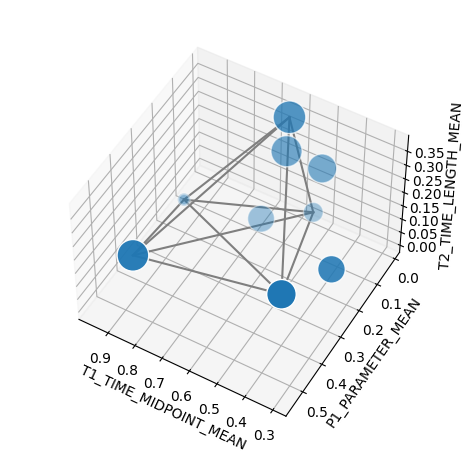

In [49]:


phy, cost = best_subset_via_powerset(sim_pareto, dim_count, lam, MAX_COST)
print(phy,cost)
elev = 50
azim = 120
ax_dist = 12
graph_filename = extra_tag + "pw-subsetsel-lambda" + str(lam) + ".pdf"
plot_graph_with_edges_from_subset(sim_pareto, phy, elev, azim, ax_dist, dims, graph_filename)

In [50]:
phy

(1, 3, 4, 5, 6)

In [51]:
get_tests_by_ids(csv_filename,sim_pareto,phy)

,NAME,TESTTAG,T1_TIME_MIDPOINT_MEAN,T2_TIME_LENGTH_MEAN,T3_TIME_MIDPOINT_VAR,P1_PARAMETER_MEAN,P2_PARAMETER_VARIANCE,O0_TOTAL_COUNT,O1_FUZZRANGE_COUNT,O2_DELAY_COUNT,O3_DELETION_COUNT,METRIC_Q
102,Test_103_20_06_2023_16_00_58,1,0.961082,0.000044,0.000000,0.122587,0.000000,1.0,1.0,0.0,0.0,0.231818
157,Test_158_20_06_2023_17_16_31,1,0.624207,0.378752,0.195288,0.045894,0.000041,2.0,2.0,0.0,0.0,0.995455
160,Test_161_20_06_2023_17_31_53,1,0.821790,0.267080,0.167038,0.547643,0.004407,2.0,2.0,0.0,0.0,0.972727
173,Test_174_20_06_2023_17_47_19,1,0.372400,0.232132,0.000000,0.445226,0.000000,1.0,1.0,0.0,0.0,0.922727
186,Test_187_20_06_2023_18_02_50,1,0.549837,0.030482,0.000000,0.013301,0.000000,1.0,1.0,0.0,0.0,0.663636


In [36]:
use_approx_algorithm = True

#plt.close()
sim = create_sim_graph_from_data(csv_filename, ['T1_TIME_MIDPOINT_MEAN', 'T2_TIME_LENGTH_MEAN', 'P1_PARAMETER_MEAN'])
sim_normalised = normalise_dimensions(sim)

lam = 0.0
FIXED_COST_BUDGET = 6

if use_approx_algorithm:
    phy_best = max_sum_divergence_approx(sim_normalised, FIXED_COST_BUDGET, lam)    
else:
    phy = best_subset_via_powerset(sim_normalised, lam)
    
selection_to_plot = phy_best
edge_selection = selection_to_plot
plot_graph_with_edges_from_subset(sim, edge_selection)

Max weight: 146->157,weight=1.9863636363636366
Number of nodes in Phy=2
Max weight: 71->189,weight=1.9681818181818183
Number of nodes in Phy=4
Max weight: 160->211,weight=1.95
Number of nodes in Phy=6


TypeError: plot_graph_with_edges_from_subset() missing 5 required positional arguments: 'elev', 'azim', 'ax_dist', 'dim_names', and 'filename'